In [1]:
import tensorflow as tf
from tensorflow.keras import models, Sequential, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_data = tf.data.Dataset.list_files('Tomato/*/*', shuffle = True)

In [3]:
for file in img_data.take(10):
    print(file.numpy())

b'Tomato\\Tomato_healthy\\b6fa2d79-dac1-42c6-a074-9d013843bb11___GH_HL Leaf 276.1.JPG'
b'Tomato\\Tomato_Early_blight\\72c6a88e-87d8-45cb-8001-3dd67f90d46c___RS_Erly.B 8245.JPG'
b'Tomato\\Tomato_healthy\\43f6d6f0-be8e-4120-8c86-fad3bcfd5c03___RS_HL 0180.JPG'
b'Tomato\\Tomato_healthy\\14f9c049-aeb8-4cfb-84a7-cd39526b8b20___RS_HL 0534.JPG'
b'Tomato\\Tomato_healthy\\1ebf9add-aa7f-4a84-adbf-67f700f918bc___GH_HL Leaf 437.JPG'
b'Tomato\\Tomato_Late_blight\\0a4b3cde-c83a-4c83-b037-010369738152___RS_Late.B 6985.JPG'
b'Tomato\\Tomato_Late_blight\\050ddb3f-1eb7-4905-8fa3-fc537dc50b7a___GHLB2 Leaf 9042.JPG'
b'Tomato\\Tomato_Late_blight\\d491156d-bcb8-47b9-b6b9-3f1d2dc1777f___GHLB2 Leaf 8779.JPG'
b'Tomato\\Tomato_healthy\\2aeb668a-251a-4f68-b52f-aadeb3376d55___RS_HL 9744.JPG'
b'Tomato\\Tomato_Late_blight\\2e8f61d8-0d5d-46e3-a597-ede96855a4fe___RS_Late.B 5352.JPG'


In [4]:
print(len(img_data))

4500


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 20

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names

In [9]:
print(class_names)

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


In [11]:
len(dataset)

71

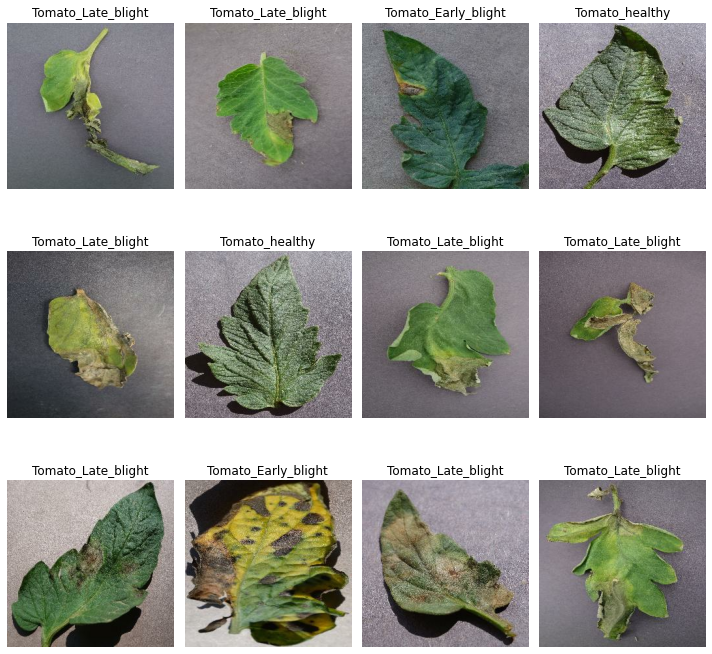

In [12]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
plt.tight_layout()

In [13]:
def train_test_split(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    train_size = int(ds_size*train_split)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 20)
    val_size = int(ds_size*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).take(val_size)
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds = train_test_split(dataset)

In [15]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

56
7
7


In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomZoom((0.2,0.3))
])

In [20]:
CHANNELS = 3
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_class = len(class_names)
model = tf.keras.Sequential([
    resize_and_rescale,
#     data_augmentation,
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((3,3)),
    layers.Conv2D(32,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((3,3)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(32,activation = 'relu'),
    layers.Dense(n_class, activation='softmax')
])
model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (64, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (64, 254, 254, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (64, 84, 84, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (64, 82, 82, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (64, 27, 27, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (64, 25, 25, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (64, 8, 8, 32)           

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size= BATCH_SIZE,
    verbose = 1,
    validation_data= val_ds
)

Epoch 1/20
56/56 [==============================] - 356s 6s/step - loss: 0.9220 - accuracy: 0.5579 - val_loss: 0.7278 - val_accuracy: 0.6540
Epoch 2/20
56/56 [==============================] - 275s 5s/step - loss: 0.4663 - accuracy: 0.7802 - val_loss: 0.3728 - val_accuracy: 0.8259
Epoch 3/20
56/56 [==============================] - 258s 5s/step - loss: 0.3600 - accuracy: 0.8472 - val_loss: 0.2889 - val_accuracy: 0.8616
Epoch 4/20
56/56 [==============================] - 314s 6s/step - loss: 0.3043 - accuracy: 0.8681 - val_loss: 0.2842 - val_accuracy: 0.8728
Epoch 5/20
56/56 [==============================] - 299s 5s/step - loss: 0.2846 - accuracy: 0.8850 - val_loss: 0.2259 - val_accuracy: 0.8884
Epoch 6/20
56/56 [==============================] - 263s 5s/step - loss: 0.2647 - accuracy: 0.8924 - val_loss: 0.3306 - val_accuracy: 0.8438
Epoch 7/20
56/56 [==============================] - 246s 4s/step - loss: 0.2158 - accuracy: 0.9124 - val_loss: 0.2655 - val_accuracy: 0.8817
Epoch 8/20
56

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

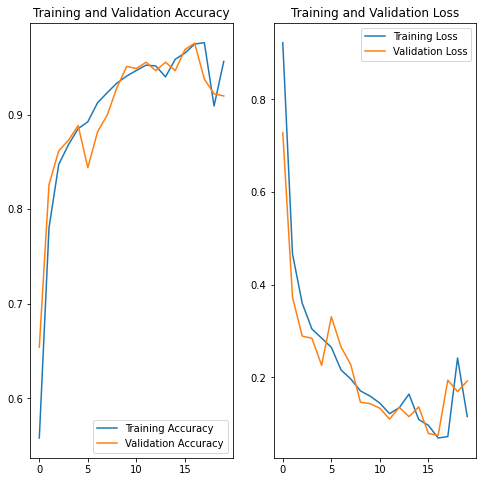

In [25]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

plt.show()

first image to predict
first image actual label :  Tomato_Late_blight
Predicted label :  Tomato_Late_blight


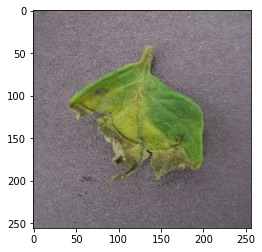

In [27]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label : ",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [31]:
def predictions(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predict_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predict_class, confidence

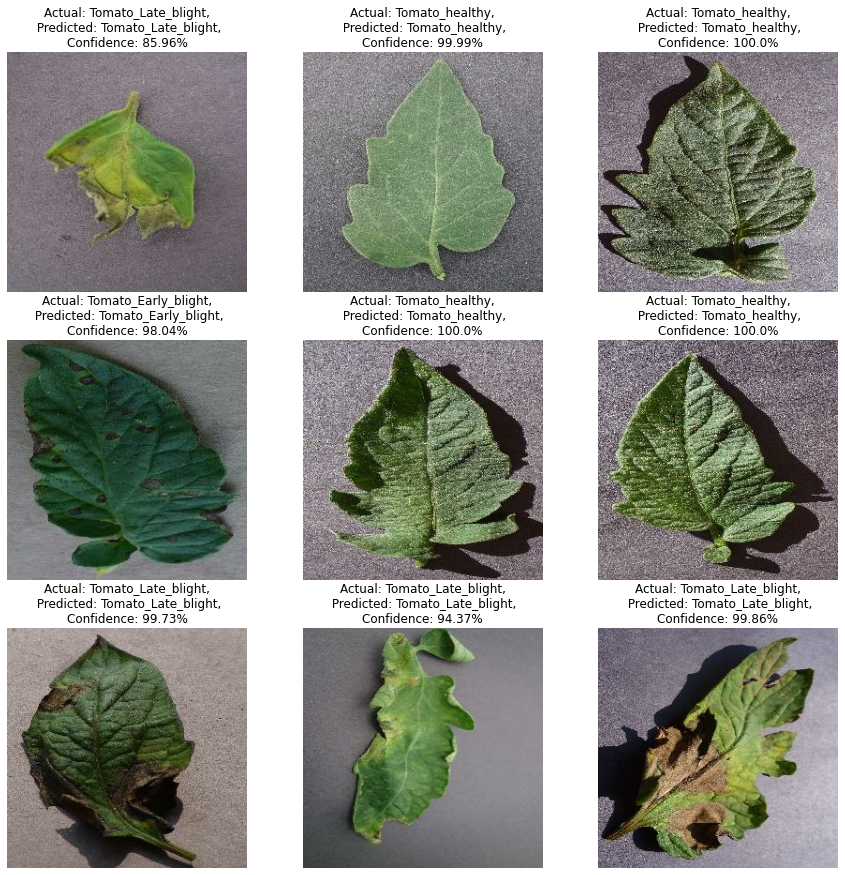

In [32]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predictions(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")

In [33]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [90]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [91]:
model.save_weights("model_weights.h5")

In [92]:
from tensorflow.keras.models import model_from_json

In [93]:
json_file = open('model.json','r')
load_model_json = json_file.read()
json_file.close()

In [94]:
loaded_model = model_from_json(load_model_json)

In [95]:
loaded_model.load_weights('model_weights.h5')

In [96]:
loaded_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

In [99]:
model_version = 'tomato_model'
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/tomato_model\assets


In [1]:
import numpy as np